In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import seaborn as sns

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')
#nltk.download('vader_lexicon')

In [49]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.model_max_length = 512

## Tools

In [43]:
android_df = pd.read_csv("android.csv")
apple_df = pd.read_csv("apple.csv")
df = apple_df
df

,year,rating,review,title
0,2018,5,Kayak has been a fantastic company to use for ...,A joy to use
1,2022,1,I’ve used hopper forever as I travel monthly. ...,Use hopper instead
2,2019,5,"I got this app for one plane flight, simple as...",I love this app
3,2018,4,I've been using Kayak to book my flights for a...,Great Site
4,2019,5,This is such a good app so much better than Tr...,Update!
...,...,...,...,...
4275,2013,5,I love this app. You can enter specific travel...,Love it
4276,2013,5,"Overall, very functional app. Was very useful ...",Great app
4277,2013,5,Great app. I just updated the app on the sep 9...,Updates
4278,2013,3,I like this app because of the speed in giving...,Compare


In [44]:
def nltkModel(df):
    res = {}
    sia = SentimentIntensityAnalyzer()
    for i, row in df.iterrows():
        text = row['review']
        myid = i
        res[myid] = sia.polarity_scores(text)
    df_res = pd.DataFrame(res).T
    return df_res.merge(df,left_index=True,right_index=True)

In [51]:
def robertaOne(example):
    encoded_text = tokenizer(example, return_tensors='pt',padding='max_length', truncation=True, max_length=514)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

def robertaModel(df):
    res = {}
    for i, row in df.iterrows():
        text = row['review']
        myid = i
        res[myid] = robertaOne(text)
    df_res = pd.DataFrame(res).T
    return df_res.merge(df,left_index=True,right_index=True)


In [47]:
res = nltkModel(df)

In [ ]:
finalres = robertaModel(res)

In [53]:
res

,neg,neu,pos,compound,year,rating,review,title
0,0.000,0.824,0.176,0.9872,2018,5,Kayak has been a fantastic company to use for ...,A joy to use
1,0.058,0.878,0.064,0.3472,2022,1,I’ve used hopper forever as I travel monthly. ...,Use hopper instead
2,0.096,0.771,0.134,0.8965,2019,5,"I got this app for one plane flight, simple as...",I love this app
3,0.017,0.832,0.150,0.9654,2018,4,I've been using Kayak to book my flights for a...,Great Site
4,0.011,0.785,0.204,0.9820,2019,5,This is such a good app so much better than Tr...,Update!
...,...,...,...,...,...,...,...,...
4275,0.084,0.710,0.206,0.5859,2013,5,I love this app. You can enter specific travel...,Love it
4276,0.000,0.701,0.299,0.8189,2013,5,"Overall, very functional app. Was very useful ...",Great app
4277,0.000,0.714,0.286,0.8622,2013,5,Great app. I just updated the app on the sep 9...,Updates
4278,0.000,0.915,0.085,0.3506,2013,3,I like this app because of the speed in giving...,Compare


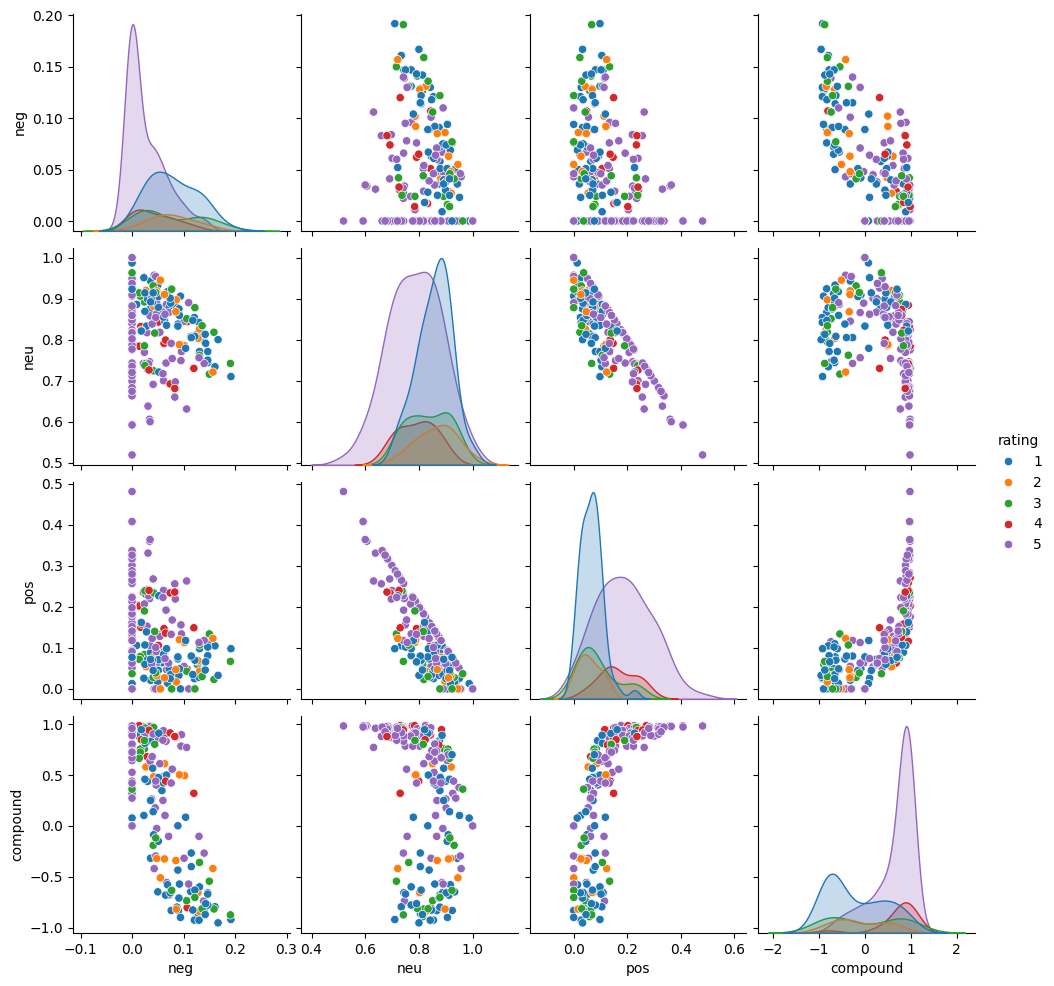

In [55]:
sns.pairplot(data=finalres,
             vars=['neg', 'neu', 'pos',"compound"],
            hue='rating',
            palette='tab10')
plt.show()

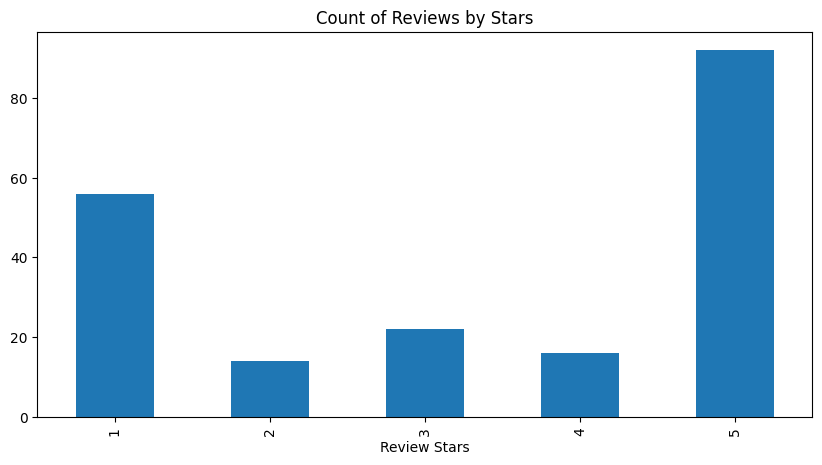

In [56]:
ax = finalres['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()